# 5.11.21

In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load IVAC data (100 indicators on salt bridge distances)

In [29]:
livac_trajs = np.load("../../data/sb_ind100_TICA/livac_trajs.npy", allow_pickle=True)
livac_arr = np.concatenate(livac_trajs)
models_km100 = np.load("../../data/sb_ind100_TICA/models.npy", allow_pickle=True)

In [30]:
# split data into trajectories
traj_lens = [len(traj) for traj in livac_trajs]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

# Load CVs 

In [31]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [32]:
cv_trajs = np.split(cv_arr, traj_inds)

In [8]:
with np.load("../../data/raw_feat/ri126_dist.npz", allow_pickle=True) as f:
    ri_trajs = f["arr_0"]
ri_arr = np.concatenate(ri_trajs)
ri_arr.shape

(6580000, 5)

In [ ]:
#

In [43]:
with np.load("../../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    sb_trajs = f["arr_0"]

In [31]:
print(len(sb_trajs))
print(sb_trajs[0].shape)

1295
(3000, 60)


In [32]:
sb_arr = np.concatenate(sb_trajs)
print(sb_arr.shape)

(6580000, 60)


In [33]:
# useful salt bridges
# R223-D129, R226-D129, R229-D129, R226-D186, R229-D186, R232-D186
sb_ids = [36, 42, 48, 46, 52, 58]

# Whiten basis of salt bridge distances

In [13]:
data_white, L = util.svd_whiten(sb_arr, 1)

In [ ]:
np.save("../../data/feadd/data_white.npy", data_white)

In [14]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

# Compute weights 

In [15]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(np.split(data_white, traj_inds), lag)
    weights.append(com)

Computing change of measure for lag 1
Computing change of measure for lag 2
Computing change of measure for lag 5
Computing change of measure for lag 10
Computing change of measure for lag 20
Computing change of measure for lag 30
Computing change of measure for lag 40
Computing change of measure for lag 50
Computing change of measure for lag 100
Computing change of measure for lag 200
Computing change of measure for lag 300
Computing change of measure for lag 400
Computing change of measure for lag 500
Computing change of measure for lag 1000
Computing change of measure for lag 2000


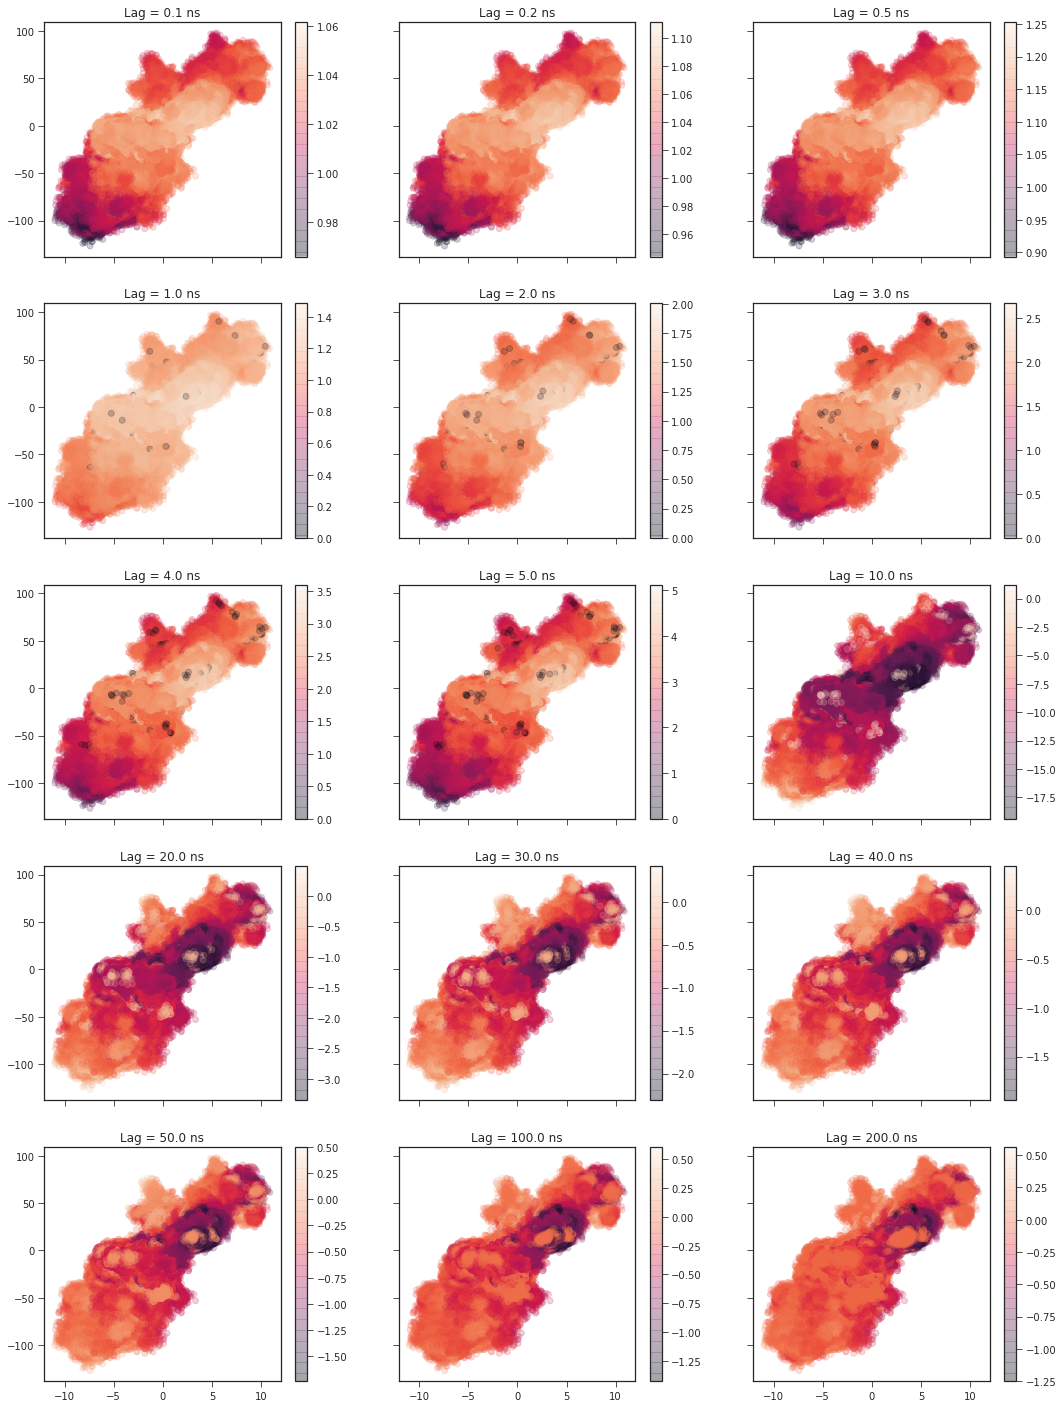

In [16]:
f, axes = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for i, (lag, ax, w) in enumerate(zip(lags, axes.flat, weights)):
    h = ax.scatter(
        cv_arr[::10, 0],
        cv_arr[::10, 1],
        c=np.concatenate(w)[::10],
        cmap="rocket",
        alpha=0.2,
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")

In [ ]:
np.save("../../data/")

# Indicator basis 

## Dimension reduction with VAC, go to 10 dimensions 

In [17]:
with np.load("../../data/raw_feat/feat1_raw_reduced.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [18]:
data.shape

(6580000, 518)

In [19]:
data_trajs = np.split(data, traj_inds)

In [20]:
ivac = ivac.LinearIVAC(minlag=1, maxlag=3000, nevecs=10, addones=False, adjust=True)
ivac.fit(data_trajs)

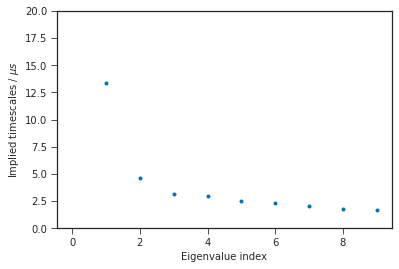

In [23]:
# f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# plt.savefig('../fi-radial-its.png', dpi=300)

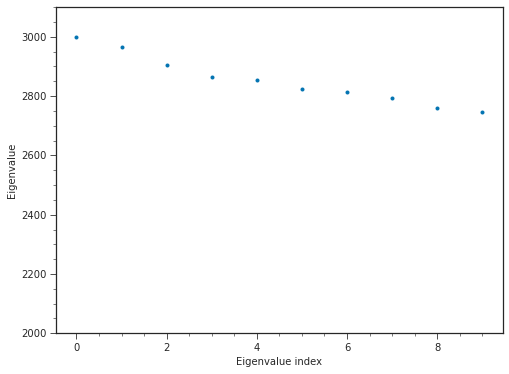

In [25]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([2000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# plt.savefig('../fig/ivac-radial-evals.png', dpi=300)

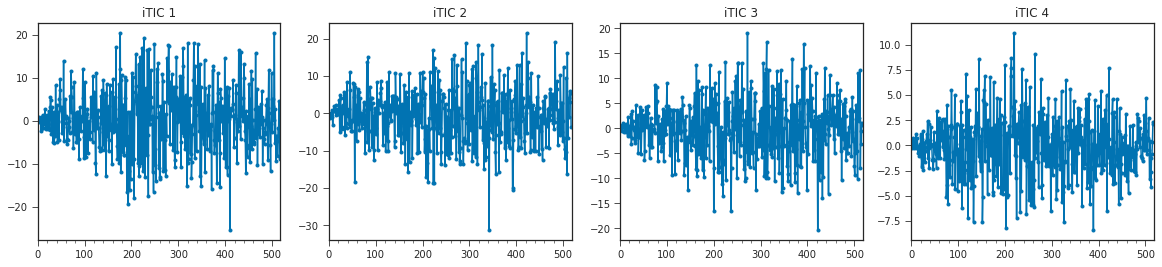

In [26]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(ivac.evecs[i + 1], ".-")
    ax.set_xlim([0, 518])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

# plt.savefig('../fig/ivac-radial-evecs.png', dpi=300)

In [27]:
ivac_trajs = ivac.transform(data_trajs)
ivac_arr = np.concatenate(ivac_trajs)
ivac_arr.shape

(6580000, 10)

## Clustering on TICA coordinates 

In [28]:
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=ivac_arr, k=200, max_iter=100, n_jobs=16
)

11-05-21 13:45:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 14 steps.


In [ ]:
dtrajs = km.dtrajs

In [ ]:
np.save("../../data/raw_feat/feat1_ivac_ind200", dtrajs)

In [8]:
dtrajs = np.load("../../data/raw_feat/feat1_ivac_ind200.npy")

In [10]:
dtrajs.shape

(1, 6580000)

In [15]:
dtrajs = np.squeeze(dtrajs)

In [16]:
dtrajs.shape

(6580000,)

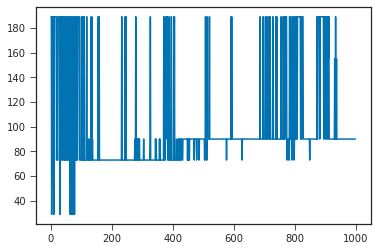

In [18]:
plt.plot(dtrajs[:1000])

In [21]:
# indicator basis
data_ind_arr = np.zeros((len(dtrajs), 200))
for i in range(200):
    data_ind_arr[dtrajs == i, i] = 1
data_ind_trajs = np.split(data_ind_arr, traj_inds)

In [22]:
data_ind_arr.shape

(6580000, 200)

## COM calculation

In [10]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

In [25]:
weights_ind = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(data_ind_trajs, lag)
    weights_ind.append(com)

Computing change of measure for lag 1


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.9434e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.06744e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 5


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.31199e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 10


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=7.10917e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 20


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=6.48033e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 30


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.30738e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 40


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.2925e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 50


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=3.83936e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 100


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=7.10082e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 200


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.24934e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 300


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=3.87971e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 400


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=7.33127e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 500


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=3.86929e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 1000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.5326e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=7.5587e-20): result may not be accurate.
  coeffs = linalg.solve(a, b)


In [26]:
np.save("../../data/coms_feat1_ind200", weights_ind)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
weights_ind = np.load("../../data/coms_feat1_ind200.npy", allow_pickle=True)

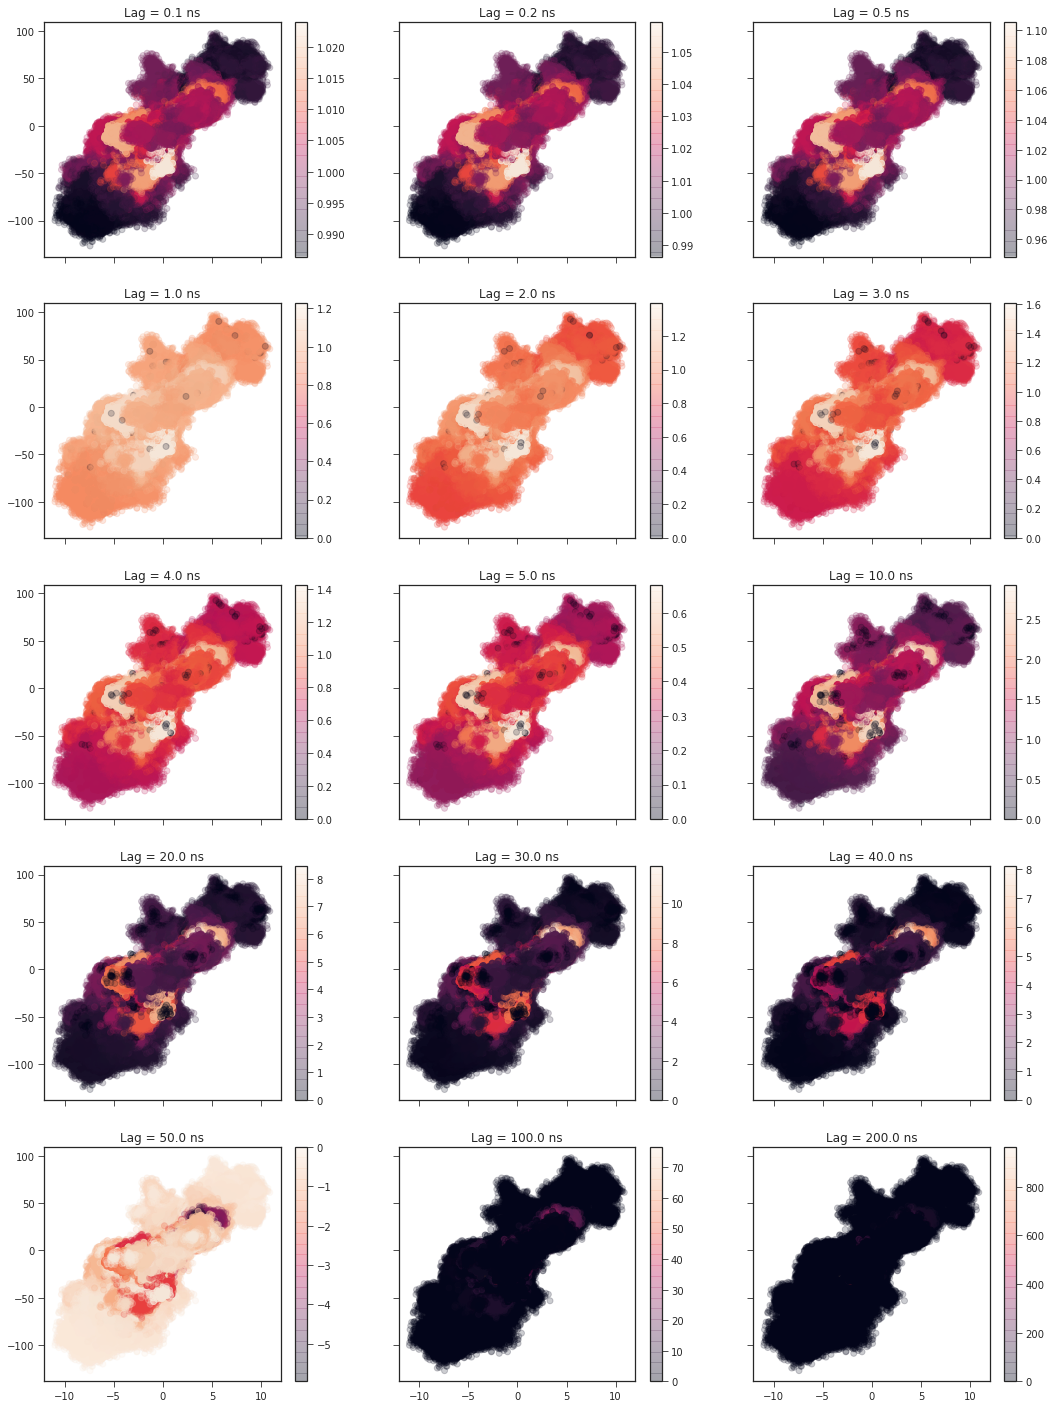

In [34]:
f, axes = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for i, (lag, ax, w) in enumerate(zip(lags, axes.flat, weights_ind)):
    h = ax.scatter(
        cv_arr[::10, 0],
        cv_arr[::10, 1],
        c=np.concatenate(w)[::10],
        cmap="rocket",
        alpha=0.2,
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")

## PMFS 

In [11]:
dens_all = []
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

for (com, lag) in zip(weights_ind, lags):
    print(f"Density for lag {lag}")
    dens_all.append(extq.projection.density2d(dist_trajs, rot_trajs, com, xlim, ylim))

Density for lag 1
Density for lag 2
Density for lag 5
Density for lag 10
Density for lag 20
Density for lag 30
Density for lag 40
Density for lag 50
Density for lag 100
Density for lag 200
Density for lag 300
Density for lag 400
Density for lag 500
Density for lag 1000
Density for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the

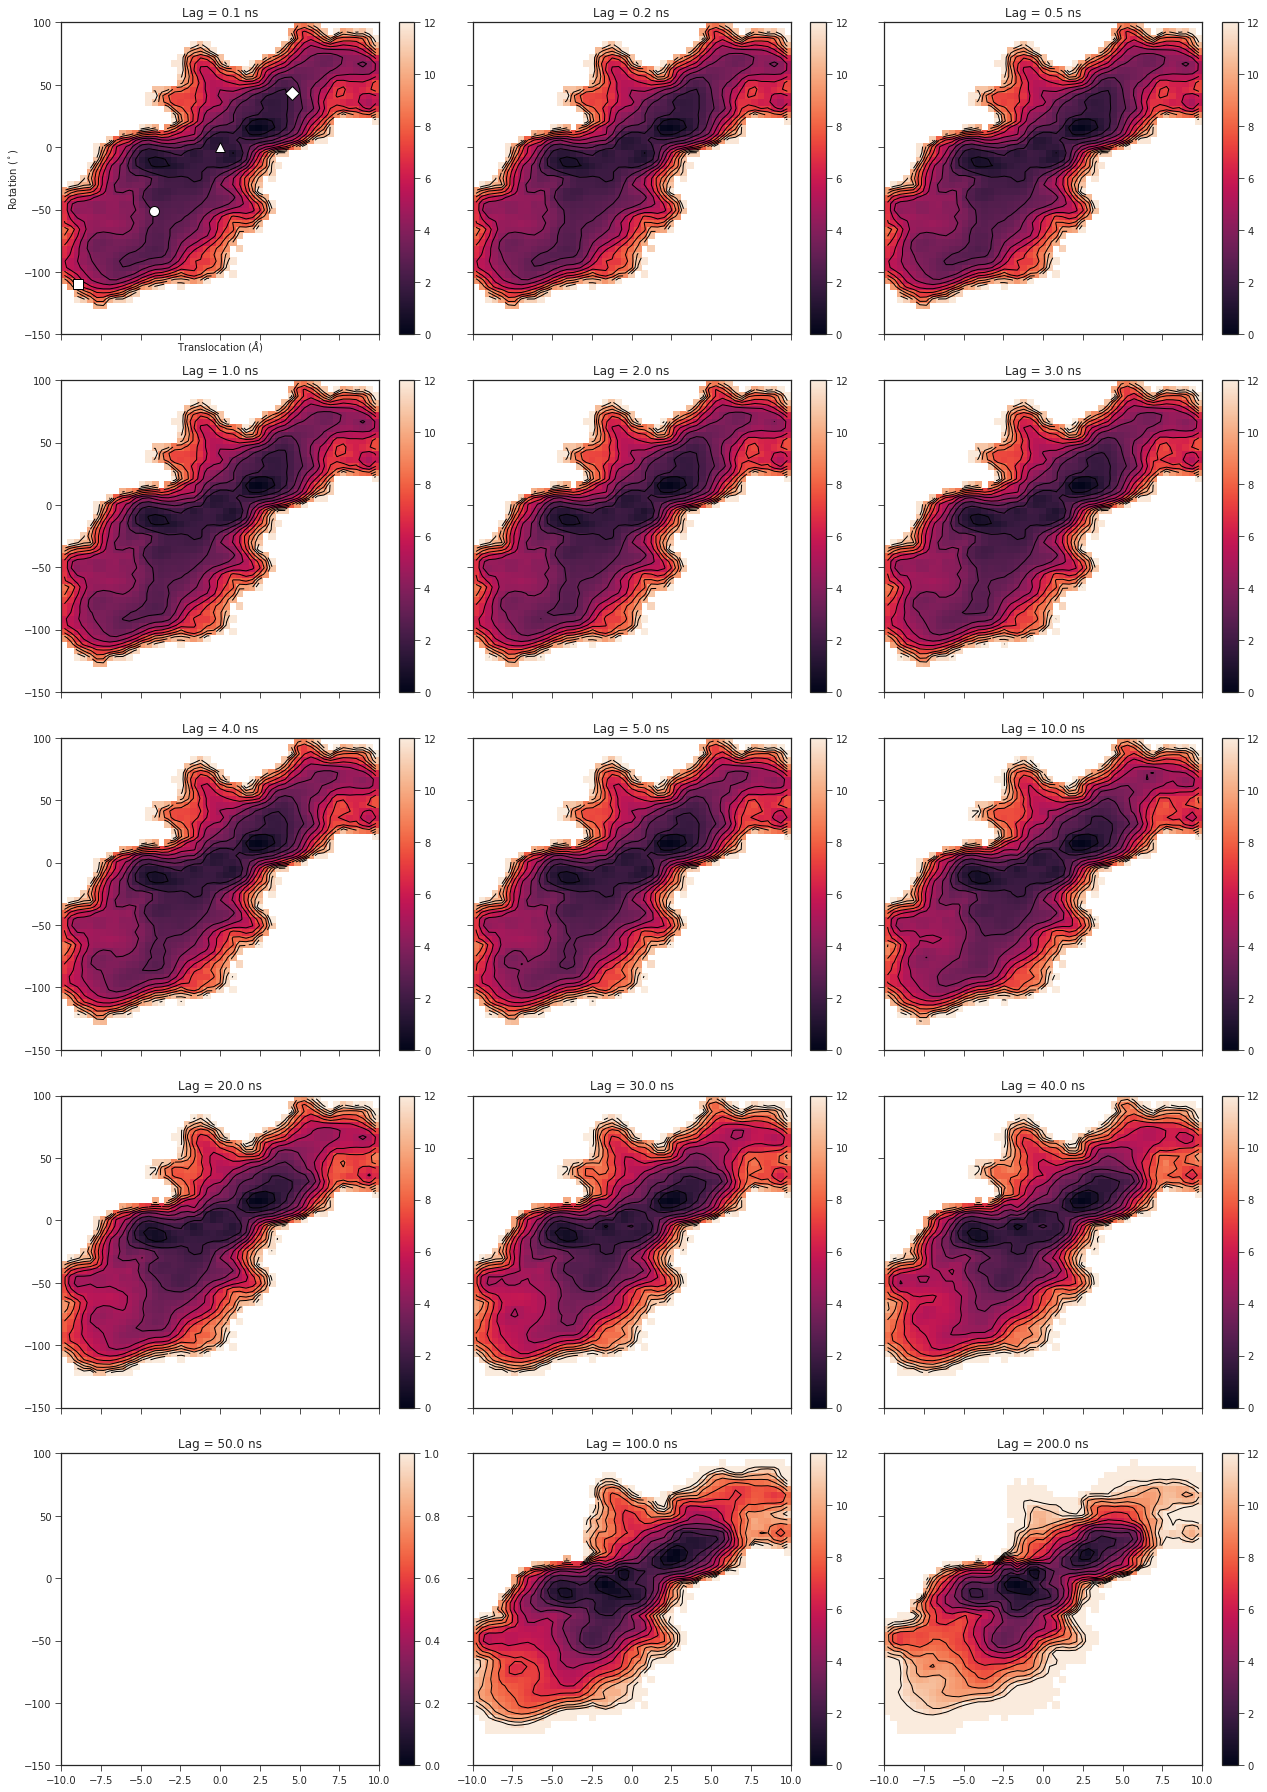

In [48]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, axes = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for i, (lag, ax, pmf) in enumerate(zip(lags, axes.flat, dens_all)):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap="rocket", vmax=12)
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_title(f"Lag = {lag * 0.1} ns")

util.format_cvs(axes[0][0])
f.tight_layout()
plt.savefig("../../fig/pmfs/feat1_ind200_pmfs_ds", dpi=400)

Plotting for selected lags

In [16]:
sns.set_context("talk")

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


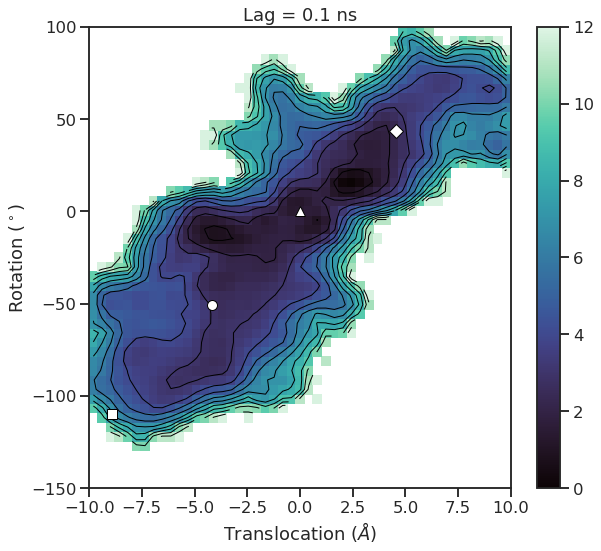

In [21]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

# lag times of 0.1
f, ax = plt.subplots(figsize=(9, 8))
# calculate energy difference against minimum
pmf = dens_all[0]
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="mako", vmax=12)
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 0.1 ns")

util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/feat1_ind200_pmfs_ds_lag1", dpi=300)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


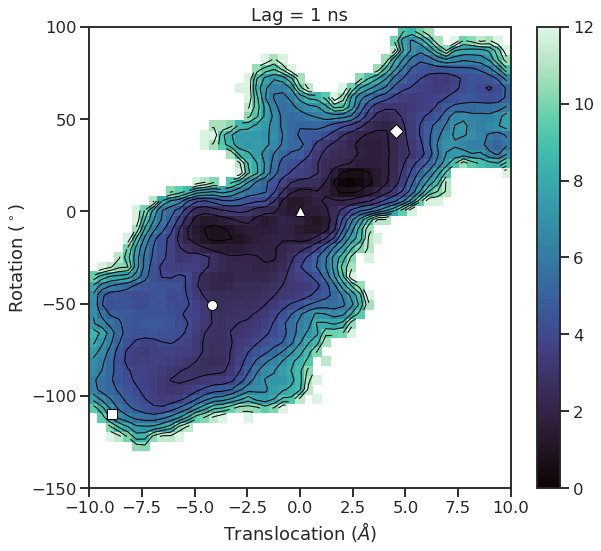

In [22]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

# lag times of 1
f, ax = plt.subplots(figsize=(9, 8))
# calculate energy difference against minimum
pmf = dens_all[3]
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="mako", vmax=12)
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 1 ns")

util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/feat1_ind200_pmfs_ds_lag10", dpi=300)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


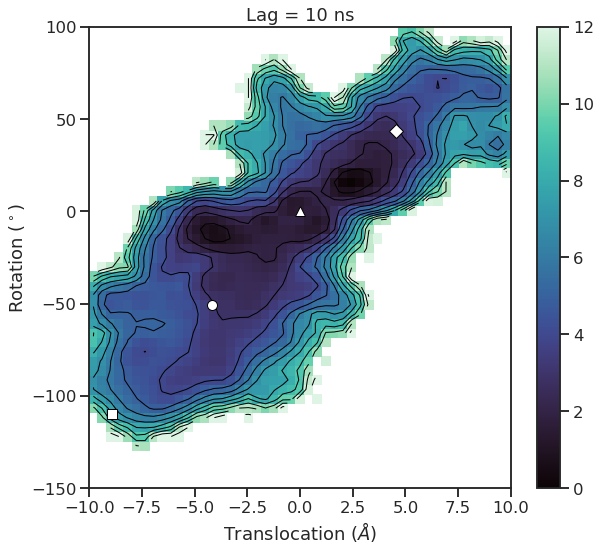

In [23]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

# lag times of 10
f, ax = plt.subplots(figsize=(9, 8))
# calculate energy difference against minimum
pmf = dens_all[8]
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="mako", vmax=12)
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 10 ns")

util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/feat1_ind200_pmfs_ds_lag100", dpi=300)

# Indicators on Feature 4 

5.13.21

In [4]:
with np.load("../../data/raw_feat/feat4_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
data.shape

(6580000, 1924)

In [8]:
data_trajs = np.split(data, traj_inds)

In [17]:
livac = ivac.LinearIVAC(minlag=1, maxlag=3000, nevecs=10, addones=False, adjust=True)
livac.fit(data_trajs)

ValueError: setting an array element with a sequence.

# Indicators on Feature 3

5.13.21

In [11]:
with np.load("../../data/raw_feat/feat3_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [12]:
data.shape

(1295,)

In [18]:
data[0].shape

(3000, 130)

In [19]:
data = list(data)

In [21]:
livac = ivac.LinearIVAC(minlag=1, maxlag=3000, nevecs=10, addones=False, adjust=True)
livac.fit(data)

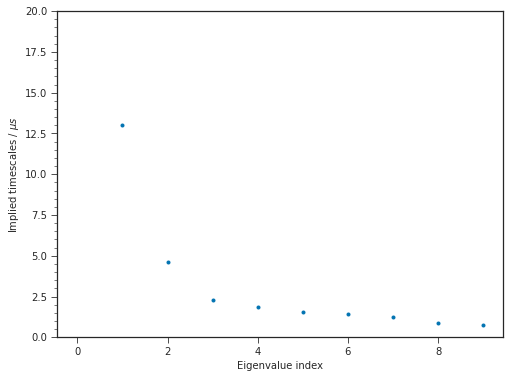

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# plt.savefig('../fi-radial-its.png', dpi=300)

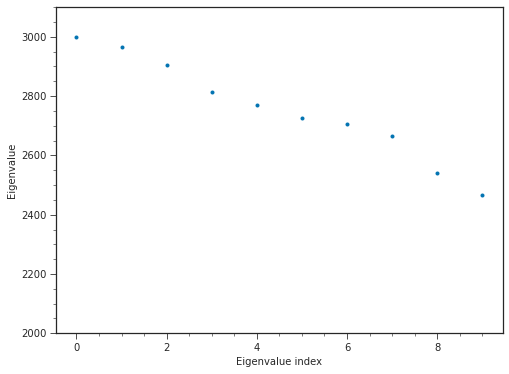

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([2000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# plt.savefig('../fig/ivac-radial-evals.png', dpi=300)

In [25]:
ivac_trajs = livac.transform(data)
ivac_arr = np.concatenate(ivac_trajs)
ivac_arr.shape

(6580000, 10)

In [26]:
np.save("../../data/raw_feat/feat3_ivac", ivac_trajs)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Clustering on TICA coordinates 

In [27]:
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=ivac_arr, k=200, max_iter=100, n_jobs=40
)

13-05-21 20:21:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 47 steps.


In [28]:
dtrajs = np.squeeze(km.dtrajs)

In [29]:
dtrajs.shape

(6580000,)

In [30]:
np.save("../../data/raw_feat/feat3_ivac_ind200", dtrajs)

In [31]:
# indicator basis
data_ind_arr = np.zeros((len(dtrajs), 200))
for i in range(200):
    data_ind_arr[dtrajs == i, i] = 1
data_ind_trajs = np.split(data_ind_arr, traj_inds)

In [32]:
data_ind_arr.shape

(6580000, 200)

## COM calculation

In [33]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

In [34]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(data_ind_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=6.44899e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=3.58637e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 5


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=8.87915e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 10


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=8.82953e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 20


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.6892e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 30


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.93329e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 40


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=8.81266e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 50


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.27538e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 100


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=5.82163e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 200


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=3.68028e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 300


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=8.4987e-20): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 400


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=7.61899e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 500


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.54363e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 1000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.47503e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.26294e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


In [36]:
np.save("../../data/coms_feat3_ind200", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [25]:
weights = np.load("../../data/coms_feat3_ind200.npy", allow_pickle=True)

## PMFs 

In [26]:
dens_all = []
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

for (com, lag) in zip(weights, lags):
    print(f"Density for lag {lag}")
    dens_all.append(extq.projection.density2d(dist_trajs, rot_trajs, com, xlim, ylim))

Density for lag 1
Density for lag 2
Density for lag 5
Density for lag 10
Density for lag 20
Density for lag 30
Density for lag 40
Density for lag 50
Density for lag 100
Density for lag 200
Density for lag 300
Density for lag 400
Density for lag 500
Density for lag 1000
Density for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


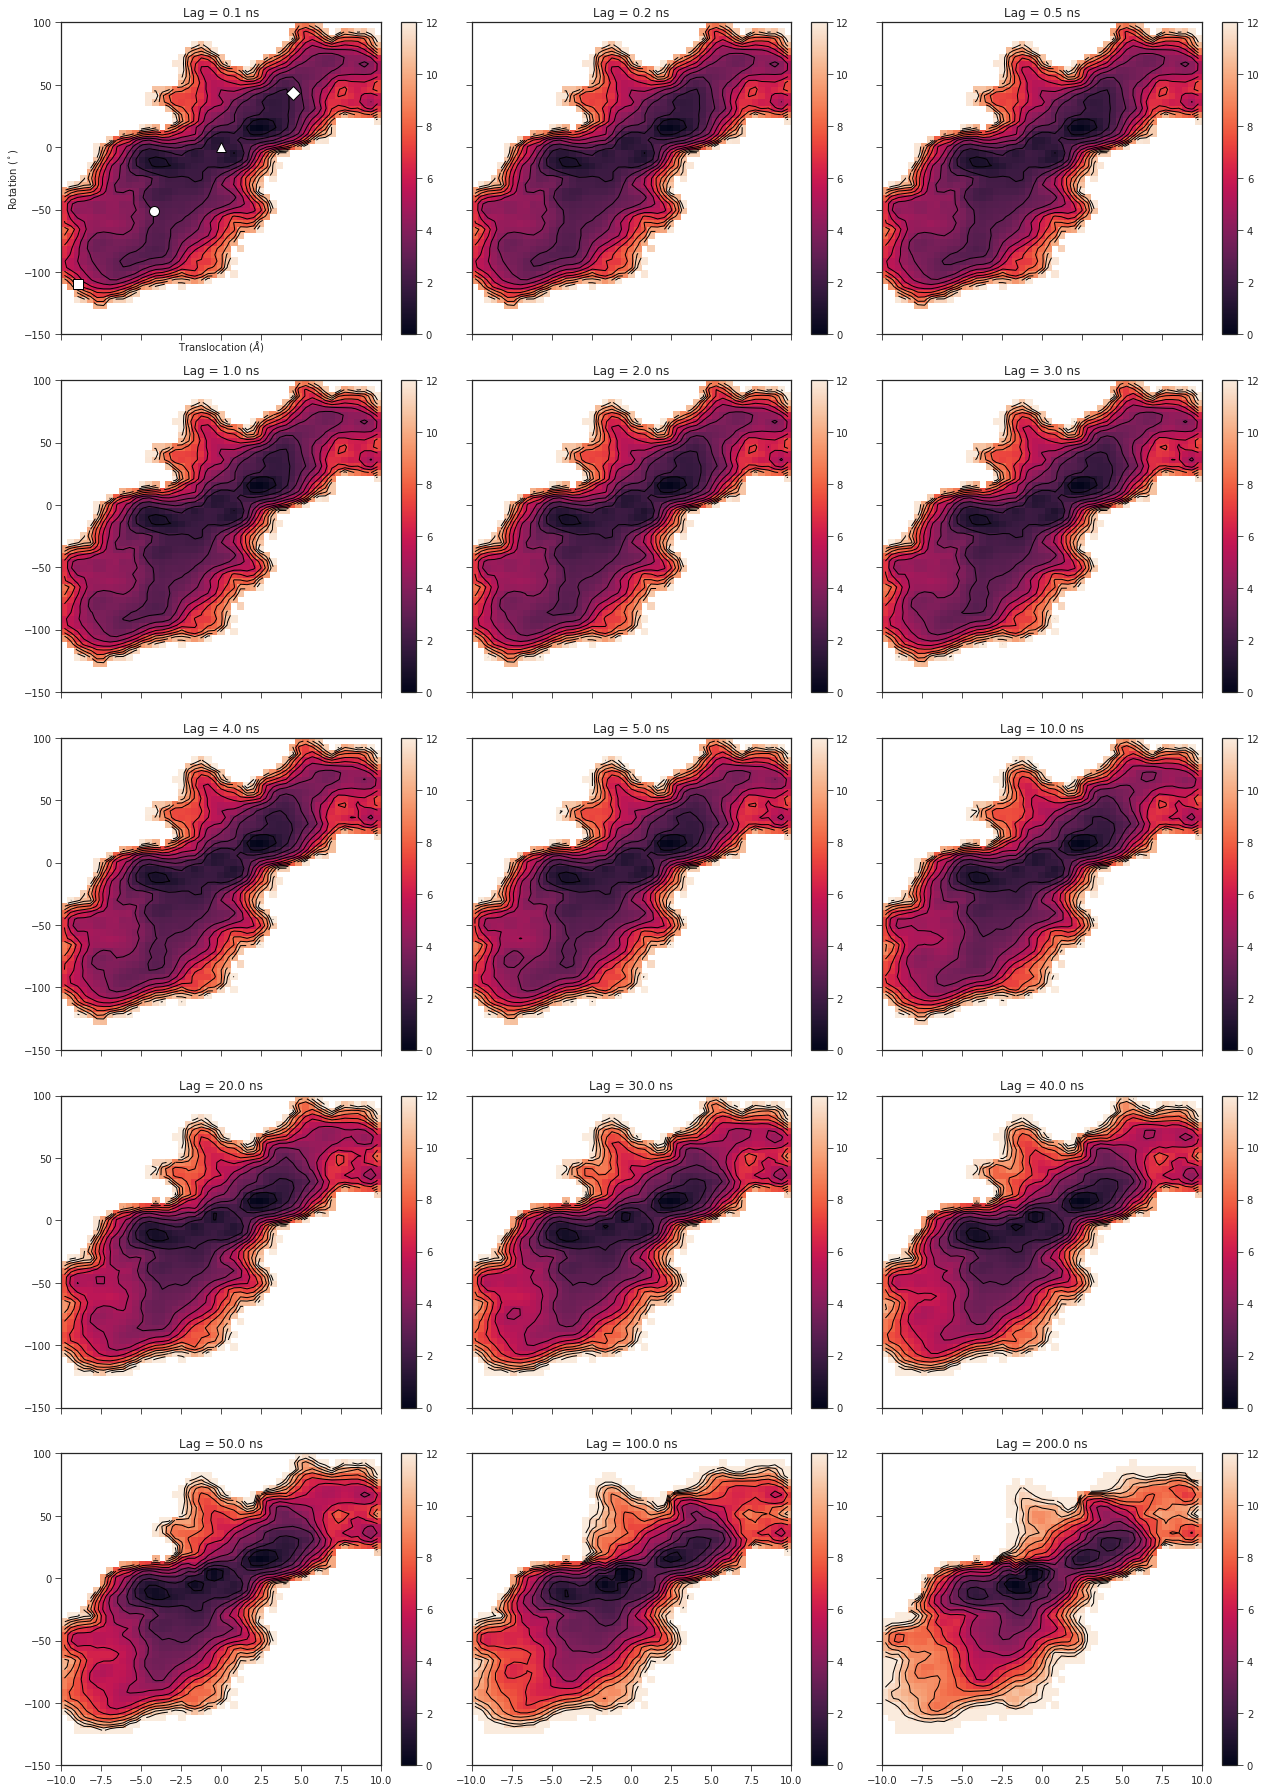

In [43]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, axes = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for i, (lag, ax, pmf) in enumerate(zip(lags, axes.flat, dens_all)):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap="rocket", vmax=12)
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_title(f"Lag = {lag * 0.1} ns")

util.format_cvs(axes[0][0])
f.tight_layout()
plt.savefig("../../fig/pmfs/feat3_ind200_pmfs_ds", dpi=400)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


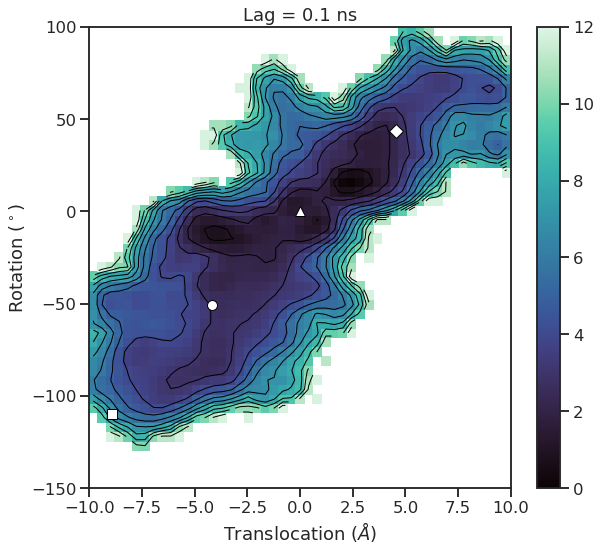

In [27]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

# lag times of 0.1
f, ax = plt.subplots(figsize=(9, 8))
# calculate energy difference against minimum
pmf = dens_all[0]
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="mako", vmax=12)
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 0.1 ns")

util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/feat3_ind200_pmfs_ds_lag1", dpi=300)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


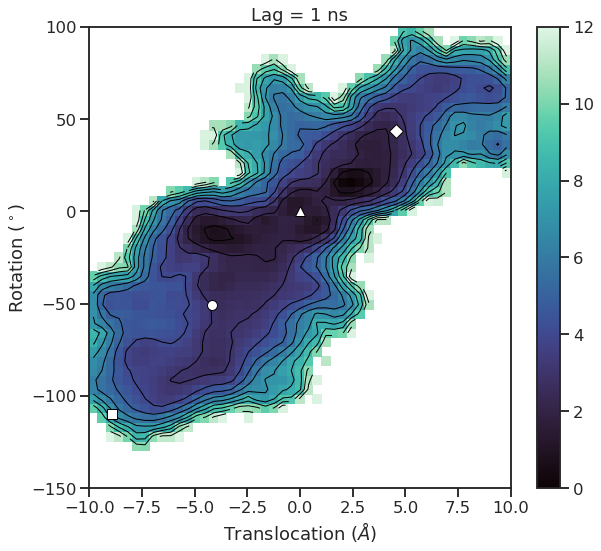

In [28]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

# lag times of 1
f, ax = plt.subplots(figsize=(9, 8))
# calculate energy difference against minimum
pmf = dens_all[3]
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="mako", vmax=12)
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 1 ns")

util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/feat3_ind200_pmfs_ds_lag10", dpi=300)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


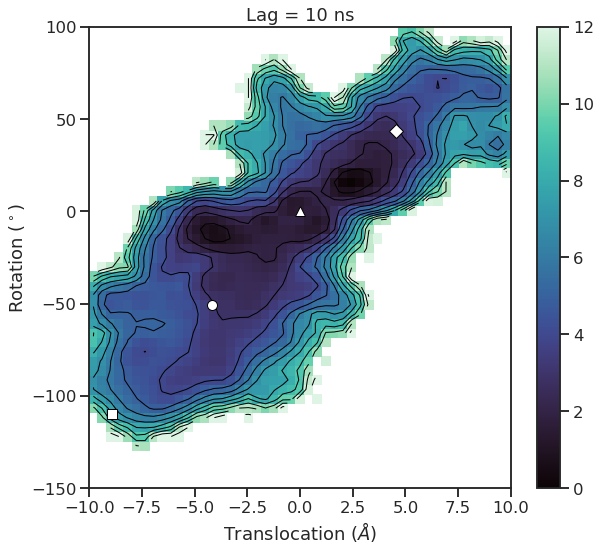

In [23]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

# lag times of 10
f, ax = plt.subplots(figsize=(9, 8))
# calculate energy difference against minimum
pmf = dens_all[8]
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="mako", vmax=12)
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 10 ns")

util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/feat1_ind200_pmfs_ds_lag100", dpi=300)

# Indicators of Feature 5

5.27.21

In [6]:
with np.load("../../data/raw_feat/feat5_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [7]:
data.shape

(1295,)

In [8]:
data[0].shape

(3000, 1924)

In [9]:
data = list(data)

In [10]:
livac = ivac.LinearIVAC(minlag=1, maxlag=3000, nevecs=10, addones=False, adjust=True)
livac.fit(data)

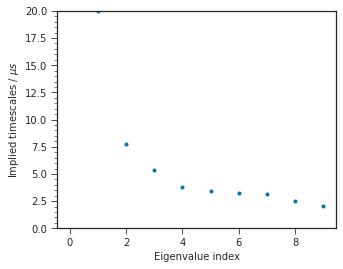

In [11]:
f, ax = plt.subplots(figsize=(5, 4))
plt.plot(livac.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

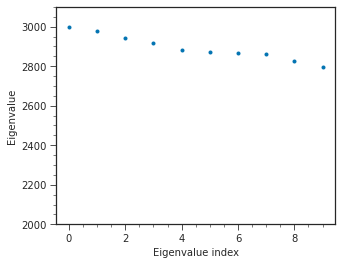

In [12]:
f, ax = plt.subplots(figsize=(5, 4))
plt.plot(livac.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([2000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

In [13]:
ivac_trajs = livac.transform(data)
ivac_arr = np.concatenate(ivac_trajs)
ivac_arr.shape

(6580000, 10)

In [14]:
np.save("../../data/raw_feat/feat5_ivac", ivac_trajs)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Clustering on TICA coordinates 

In [ ]:
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=ivac_arr, k=200, max_iter=100, n_jobs=20
)

In [ ]:
dtrajs = np.squeeze(km.dtrajs)

In [ ]:
dtrajs.shape

In [ ]:
np.save("../../data/raw_feat/feat5_ivac_ind200", dtrajs)

In [22]:
dtrajs = np.load("../../data/raw_feat/feat5_ivac_ind200.npy")

In [23]:
# indicator basis
data_ind_arr = np.zeros((len(dtrajs), 200))
for i in range(200):
    data_ind_arr[dtrajs == i, i] = 1
data_ind_trajs = np.split(data_ind_arr, traj_inds)

In [24]:
data_ind_arr.shape

(6580000, 200)

## COM calculation

In [25]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

In [26]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(data_ind_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=6.19017e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=8.48718e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 5


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.65197e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 10


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=8.27142e-20): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 20


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=4.46608e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 30


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.56849e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 40


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=3.66433e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 50


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.84844e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 100


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.89008e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 200


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.61214e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 300


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.6076e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 400


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.50687e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 500


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.48853e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 1000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.24968e-18): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=9.41947e-19): result may not be accurate.
  coeffs = linalg.solve(a, b)


In [27]:
np.save("../../data/coms_feat5_ind200", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## PMFs 

In [33]:
dens_all = []
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

for (com, lag) in zip(weights, lags):
    print(f"Density for lag {lag}")
    dens_all.append(extq.projection.density2d(dist_trajs, rot_trajs, com, xlim, ylim))

Density for lag 1
Density for lag 2
Density for lag 5
Density for lag 10
Density for lag 20
Density for lag 30
Density for lag 40
Density for lag 50
Density for lag 100
Density for lag 200
Density for lag 300
Density for lag 400
Density for lag 500
Density for lag 1000
Density for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the

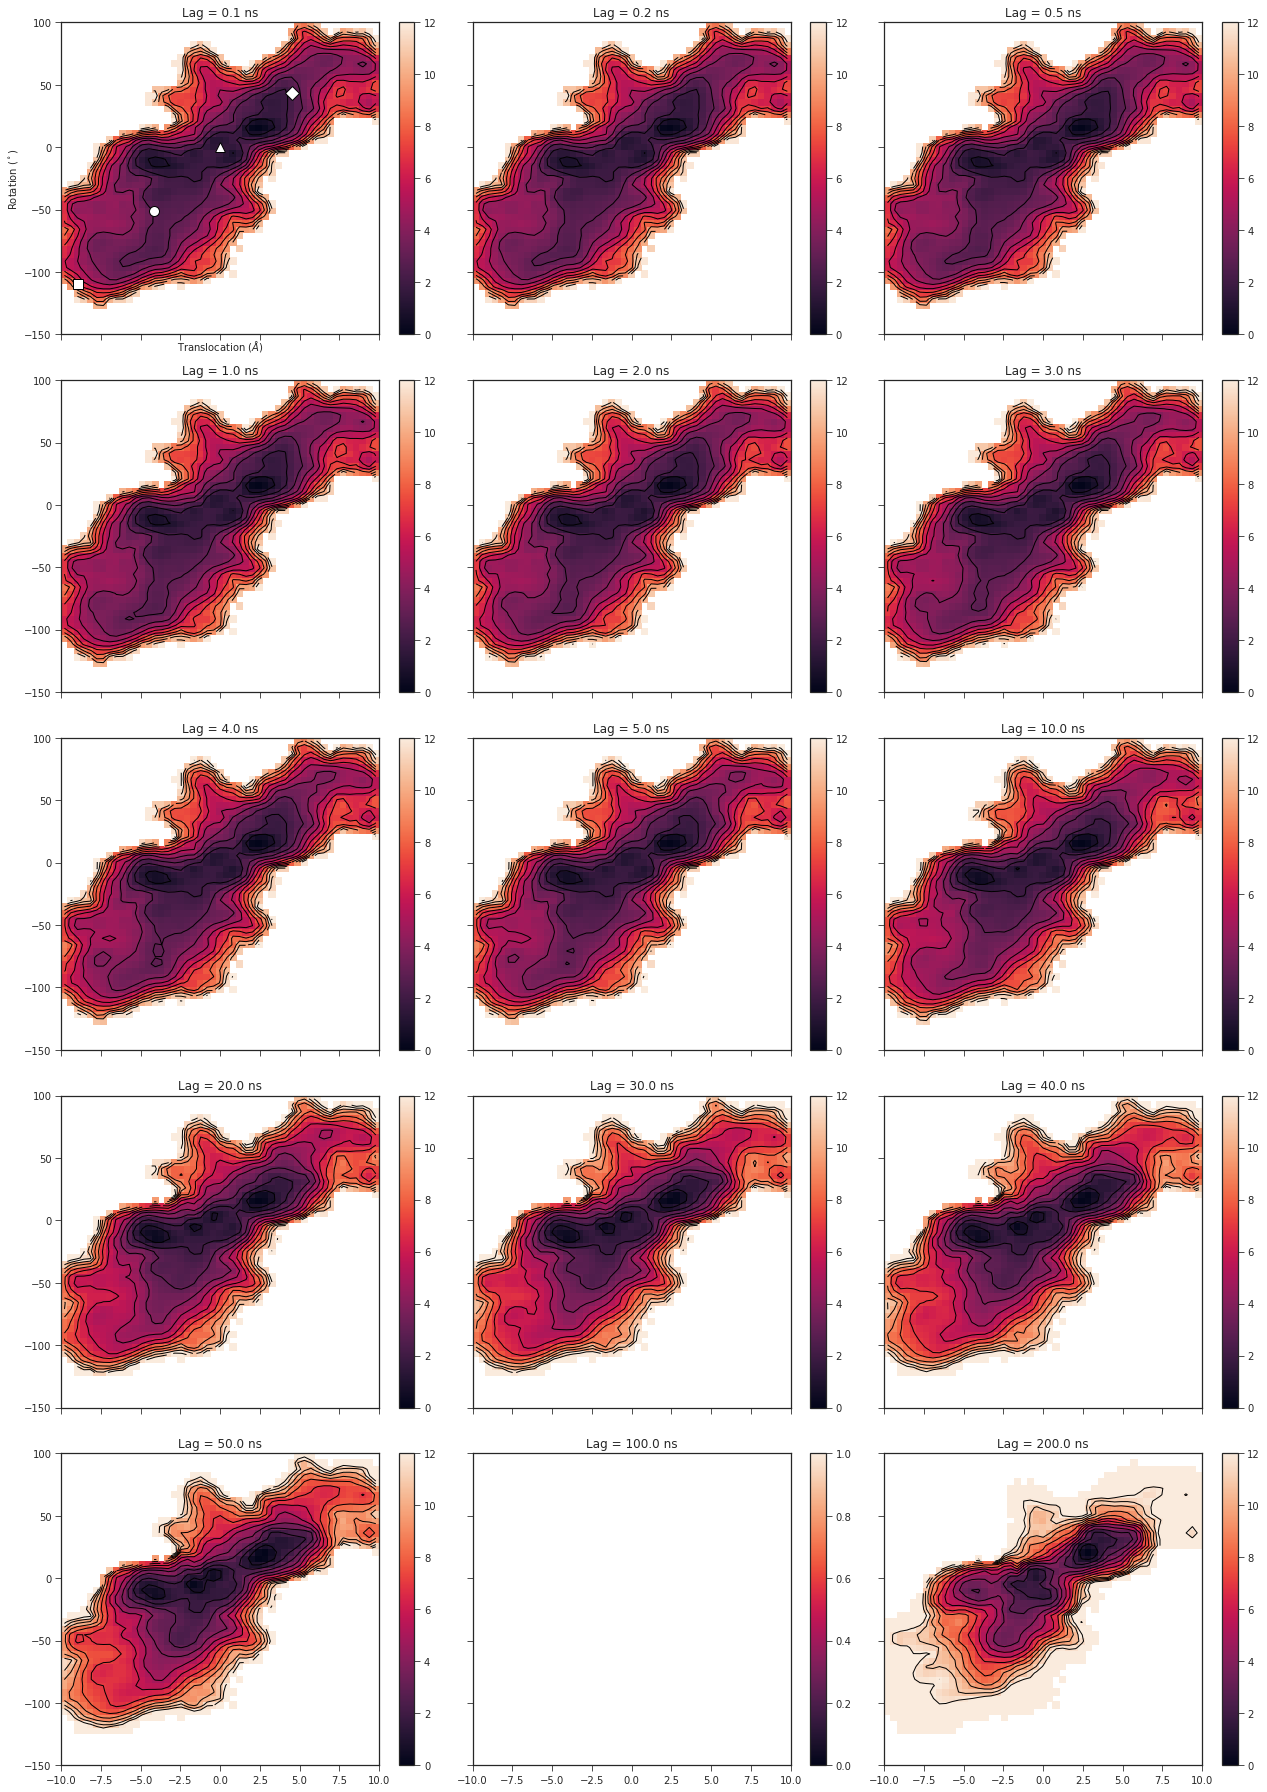

In [34]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, axes = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for i, (lag, ax, pmf) in enumerate(zip(lags, axes.flat, dens_all)):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap="rocket", vmax=12)
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_title(f"Lag = {lag * 0.1} ns")

util.format_cvs(axes[0][0])
f.tight_layout()
# plt.savefig('../../fig/pmfs/feat3_ind200_pmfs_ds', dpi=400)